# Udacity - Data Science NanoDegree
## Investigate a Dataset
### Submission By: 55thSwiss

We'll be analyzing the soccer data set [1], mostly because it could be used for predictive ML and it's sports related, both of which interest me. All analysis and computation have been done in this notebook. 

[1] https://www.kaggle.com/hugomathien/soccer

## Intro
One of the most enjoyable parts about watching sports is watching a team win. This usually has to do with the fact that winning teams score more, but in this analysis I'm going to take a look at what makes a winning team, statistically, different than a losing team beyond just the goals.

We're going to manipulate the data into two basic categories, data about individual teams and data about how these teams did against one another, then we can compare what the make-up of these teams are that played one another.

## Import Dependencies

In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
import seaborn as sns
from math import pi
import sqlite3
import datetime
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Import Data

In [2]:
with sqlite3.connect('database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    player = pd.read_sql_query("SELECT * from Player",con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes",con)
    sequence = pd.read_sql_query("SELECT * from sqlite_sequence",con)
    team_attributes = pd.read_sql_query("SELECT * from Team_Attributes",con)

## Quick Look
Since we're interested in what makes a winning team different than a losing one, a large portion of this data is not going to be utilized, namely the 'player' and 'player_attributes' data sets. Normally I wouldn't want to disregard such a large accumulation of data but for the sake of not making this about discrepancies, anomalies, or general focus on the correlation between one data set and another it will be assumed the accumulation of individual player attributes into a single 'team' is therefore represented in the 'team_attributes' data set.

In [3]:
teams.nunique()

id                  299
team_api_id         299
team_fifa_api_id    285
team_long_name      296
team_short_name     259
dtype: int64

In [4]:
team_attributes.nunique()

id                                1458
team_fifa_api_id                   285
team_api_id                        288
date                                 6
buildUpPlaySpeed                    57
buildUpPlaySpeedClass                3
buildUpPlayDribbling                49
buildUpPlayDribblingClass            3
buildUpPlayPassing                  58
buildUpPlayPassingClass              3
buildUpPlayPositioningClass          2
chanceCreationPassing               50
chanceCreationPassingClass           3
chanceCreationCrossing              56
chanceCreationCrossingClass          3
chanceCreationShooting              57
chanceCreationShootingClass          3
chanceCreationPositioningClass       2
defencePressure                     48
defencePressureClass                 3
defenceAggression                   47
defenceAggressionClass               3
defenceTeamWidth                    43
defenceTeamWidthClass                3
defenceDefenderLineClass             2
dtype: int64

In [5]:
countries.nunique()

id      11
name    11
dtype: int64

In [6]:
leagues.nunique()

id            11
country_id    11
name          11
dtype: int64

In [7]:
matches[['country_id', 
        'league_id', 
        'season', 
        'date', 
        'match_api_id', 
        'home_team_api_id', 
        'away_team_api_id']].nunique()

country_id             11
league_id              11
season                  8
date                 1694
match_api_id        25979
home_team_api_id      299
away_team_api_id      299
dtype: int64

## Merge Data

### Team and Attributes

In [8]:
# combine the df's on already existing features
teamsDF = teams.merge(team_attributes, on=['team_api_id', 'team_fifa_api_id'])
# get rid of some creationed columns from the merge
teamsDF.drop(['id_x', 'id_y'], axis=1, inplace=True)
# We only want one entry per team per year, so we need to eliminate duplicates based on the date and team name
teamsDF.drop_duplicates(subset=['date', 'team_long_name'], inplace = True)
teamsDF.sample(3)

team_api_id  team_fifa_api_id            team_long_name team_short_name  \
508         8178              32.0       Bayer 04 Leverkusen             LEV   
992         8569          110744.0             GKS Bełchatów             BEL   
573         9788              23.0  Borussia Mönchengladbach             GLA   

                    date  buildUpPlaySpeed buildUpPlaySpeedClass  \
508  2014-09-19 00:00:00                69                  Fast   
992  2011-02-22 00:00:00                47              Balanced   
573  2011-02-22 00:00:00                63              Balanced   

     buildUpPlayDribbling buildUpPlayDribblingClass  buildUpPlayPassing  \
508                  30.0                    Little                  55   
992                   NaN                    Little                  27   
573                   NaN                    Little                  46   

    buildUpPlayPassingClass buildUpPlayPositioningClass  \
508                   Mixed                   Organised   
992                   Short                   Organised   
573                   Mixed                   Organised   

     chanceCreationPassing chanceCreationPassingClass  chanceCreationCrossing  \
508                     52                     Normal                      55   
992                     45                     Normal                      51   
573                     60                     Normal                      51   

    chanceCreationCrossingClass  chanceCreationShooting  \
508                      Normal                      39   
992                      Normal                      54   
573                      Normal                      61   

    chanceCreationShootingClass chanceCreationPositioningClass  \
508                      Normal                      Organised   
992                      Normal                      Organised   
573                      Normal                      Organised   

     defencePressure defencePressureClass  defenceAggression  \
508               50               Medium                 46   
992               48               Medium                 60   
573               49               Medium                 58   

    defenceAggressionClass  defenceTeamWidth defenceTeamWidthClass  \
508                  Press                54                Normal   
992                  Press                37                Normal   
573                  Press                49                Normal   

    defenceDefenderLineClass  
508                    Cover  
992                    Cover  
573                    Cover

In [9]:
print(teams.shape)
print(team_attributes.shape)
print(teamsDF.shape)

(299, 5)
(1458, 25)
(1450, 26)


### Country, League, and Match

In [10]:
# get the initial merge
leaguesDF = countries.merge(leagues, on=['id'])
# rename
leaguesDF = leaguesDF.rename(columns={'name_x':'Country', 'name_y':'League'})
leaguesDF.sample(3)

id      Country  country_id                    League
3    7809      Germany        7809     Germany 1. Bundesliga
10  24558  Switzerland       24558  Switzerland Super League
9   21518        Spain       21518           Spain LIGA BBVA

In [11]:
# now import that 'matches' data set
leaguesDF = leaguesDF.merge(matches, on = ['country_id'])
leaguesDF.sample(3)

id_x      Country  country_id                  League   id_y  \
14122  13274  Netherlands       13274  Netherlands Eredivisie  14123   
9191    7809      Germany        7809   Germany 1. Bundesliga   9192   
12719  10257        Italy       10257           Italy Serie A  12720   

       league_id     season  stage                 date  match_api_id  \
14122      13274  2010/2011     33  2011-05-01 00:00:00        836688   
9191        7809  2012/2013     25  2013-03-10 00:00:00       1239690   
12719      10257  2014/2015     28  2015-03-22 00:00:00       1786286   

       home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
14122              9839             10235               3               2   
9191              10269              9790               0               1   
12719              9882              8636               1               0   

       home_player_X1  home_player_X2  home_player_X3  home_player_X4  \
14122             1.0             2.0             4.0             6.0   
9191              1.0             2.0             4.0             6.0   
12719             1.0             2.0             4.0             6.0   

       home_player_X5  home_player_X6  home_player_X7  home_player_X8  \
14122             8.0             3.0             5.0             7.0   
9191              8.0             5.0             2.0             8.0   
12719             8.0             3.0             5.0             7.0   

       home_player_X9  home_player_X10  home_player_X11  away_player_X1  \
14122             3.0              5.0              7.0             1.0   
9191              4.0              6.0              6.0             1.0   
12719             3.0              5.0              7.0             1.0   

       away_player_X2  away_player_X3  away_player_X4  away_player_X5  \
14122             2.0             4.0             6.0             8.0   
9191              2.0             4.0             6.0             8.0   
12719             2.0             4.0             6.0             8.0   

       away_player_X6  away_player_X7  away_player_X8  away_player_X9  \
14122             3.0             5.0             7.0             3.0   
9191              4.0             6.0             2.0             8.0   
12719             3.0             5.0             7.0             5.0   

       away_player_X10  away_player_X11  home_player_Y1  home_player_Y2  \
14122              5.0              7.0             1.0             3.0   
9191               4.0              6.0             1.0             3.0   
12719              4.0              6.0             1.0             3.0   

       home_player_Y3  home_player_Y4  home_player_Y5  home_player_Y6  \
14122             3.0             3.0             3.0             7.0   
9191              3.0             3.0             3.0             6.0   
12719             3.0             3.0             3.0             7.0   

       home_player_Y7  home_player_Y8  home_player_Y9  home_player_Y10  \
14122             7.0             7.0            10.0             10.0   
9191              7.0             7.0             9.0              9.0   
12719             7.0             7.0            10.0             10.0   

       home_player_Y11  away_player_Y1  away_player_Y2  away_player_Y3  \
14122             10.0             1.0             3.0             3.0   
9191              11.0             1.0             3.0             3.0   
12719             10.0             1.0             3.0             3.0   

       away_player_Y4  away_player_Y5  away_player_Y6  away_player_Y7  \
14122             3.0             3.0             7.0             7.0   
9191              3.0             3.0             6.0             6.0   
12719             3.0             3.0             6.0             6.0   

       away_player_Y8  away_player_Y9  away_player_Y10  away_player_Y11  \
14122             7.0            10.0             10.0             10.0   
9191         

In [12]:
a, b, c, d = countries.shape, leagues.shape, matches.shape, leaguesDF.shape
print(a)
print(b)
print(c)
print(d)

(11, 2)
(11, 3)
(25979, 115)
(25979, 118)


In [13]:
# capture only two columns
temp = teamsDF[['team_api_id', 'team_long_name']]
# rename the column to match other df for key
temp = temp.rename(columns={'team_api_id':'home_team_api_id'}) 
# make sure there's no duplicates
temp.drop_duplicates(subset=['home_team_api_id', 'team_long_name'], inplace = True)
# merge them together on 'home_team_api_id'
leaguesDF = leaguesDF.merge(temp, on=['home_team_api_id'], how='left')
# rename again for away columns
temp = temp.rename(columns={'home_team_api_id':'away_team_api_id'}) 
# merge again
leaguesDF = leaguesDF.merge(temp, on=['away_team_api_id'], how='left')
# drop some useless features
leaguesDF.drop(['id_x', 'id_y', 'country_id', 'league_id', 'stage'], axis=1, inplace=True)
# create a copy of 'leagueDF' to simplify the information even more
leaguesFinal = leaguesDF
leaguesFinal = leaguesFinal[['Country', 'League', 'season', 'date', 'match_api_id', 'team_long_name_x', 
                       'team_long_name_y', 'home_team_goal', 'away_team_goal']]

In [14]:
# rename for clarity
leaguesFinal = leaguesFinal.rename(columns={'team_long_name_x':'Home Team', 'team_long_name_y':'Away Team'})
leaguesFinal.sample(3)

Country              League     season                 date  \
17177  Poland  Poland Ekstraklasa  2014/2015  2014-10-05 00:00:00   
10926   Italy       Italy Serie A  2009/2010  2010-05-02 00:00:00   
23055   Spain     Spain LIGA BBVA  2012/2013  2012-11-04 00:00:00   

       match_api_id                  Home Team       Away Team  \
17177       1722172              Piast Gliwice  Legia Warszawa   
10926        705237                   Atalanta         Bologna   
23055       1260150  RC Deportivo de La Coruña    RCD Mallorca   

       home_team_goal  away_team_goal  
17177               3               1  
10926               1               1  
23055               1               0

In [15]:
# functions to decide the winner and loser of each match and append the df with that feature

def win(leaguesFinal):
    if leaguesFinal['home_team_goal'] > leaguesFinal['away_team_goal']:
        return leaguesFinal['Home Team']
    elif leaguesFinal['away_team_goal'] > leaguesFinal['home_team_goal']:
        return leaguesFinal['Away Team']
    elif leaguesFinal['home_team_goal'] == leaguesFinal['away_team_goal']:
        return "DRAW"
    
def loss(leaguesFinal):
    if leaguesFinal['home_team_goal'] < leaguesFinal['away_team_goal']:
        return leaguesFinal['Home Team']
    elif leaguesFinal['away_team_goal'] < leaguesFinal['home_team_goal']:
        return leaguesFinal['Away Team']
    
leaguesFinal["win"] = leaguesFinal.apply(lambda leaguesFinal:win(leaguesFinal),axis=1)
leaguesFinal["loss"] = leaguesFinal.apply(lambda leaguesFinal:loss(leaguesFinal),axis=1)

In [16]:
leaguesFinal.shape

(25979, 11)

In [17]:
leaguesFinal.sample(3)

Country                  League     season                 date  \
1638  Belgium  Belgium Jupiler League  2015/2016  2016-02-14 00:00:00   
8363  Germany   Germany 1. Bundesliga  2009/2010  2010-05-08 00:00:00   
802   Belgium  Belgium Jupiler League  2011/2012  2011-11-19 00:00:00   

      match_api_id        Home Team          Away Team  home_team_goal  \
1638       1980030     KVC Westerlo  Standard de Liège               2   
8363        674582  1. FSV Mainz 05      FC Schalke 04               0   
802        1032802      KV Mechelen   SV Zulte-Waregem               1   

      away_team_goal           win               loss  
1638               0  KVC Westerlo  Standard de Liège  
8363               0          DRAW               None  
802                1          DRAW               None

## Feature Engineering

### Team Record (Wins / Losses) DataFrame
Draws are being diregarded in this analysis because they do not help to determine what makes a winning team different than a losing team.

In [18]:
# get indices
seasons = leaguesFinal['season'].unique()
teams = teamsDF['team_long_name'].unique()
# create an empty list
df = []

# first separate by season
for i in seasons:
    season = leaguesFinal['season'] == i
    season = leaguesFinal[season]
    # then count the games won and games lost
    for j in teams:
        team_season_wins = season['win'] == j
        team_season_win_record = team_season_wins[team_season_wins].count()
        team_season_loss = season['loss'] == j
        team_season_loss_record = team_season_loss[team_season_loss].count()
        df.append((j, i, team_season_win_record, team_season_loss_record))
# create the new df and feature names
df = pd.DataFrame(df, columns=('Team', 'Seasons', 'Wins', 'Losses'))
# rename the team column to use as a key
df = df.rename(columns={'Team':'Home Team'})
# take just the information we want to merge ('League') plus a key column for merging
df2 = leaguesFinal[['Home Team', 'League']]
# clean it up, we only want one team name per league, there are no dates associated with df2
df2.drop_duplicates(subset = ['Home Team'],inplace = True)
# the merge
df = df.merge(df2, on = 'Home Team')
# change the feature name back
df = df.rename(columns={'Home Team':'Team'}) 
# create an identifiable df name
teamRecords = df[['League', 'Team', 'Seasons', 'Wins', 'Losses']]
# drop some outlier rows with odd data,
# seemed to consistantly contain '0' for either win or loss
teamRecords = teamRecords[teamRecords.Wins != 0]
teamRecords = teamRecords[teamRecords.Losses != 0]
teamRecords.sample(5)

League                   Team    Seasons  Wins  Losses
1087             Italy Serie A              Sampdoria  2015/2016    10      18
1551        Poland Ekstraklasa         Zagłębie Lubin  2015/2016    12       9
2224  Switzerland Super League               FC Vaduz  2008/2009     5      24
1512        Poland Ekstraklasa  Jagiellonia Białystok  2008/2009     9      14
2197  Switzerland Super League               FC Basel  2013/2014    19       2

### Team Goals by Season

In [19]:
# create another list
df = []
# group by 'home' or 'away' and season and sum the goal column
home_goals = leaguesFinal.groupby(('Home Team', 'season'))['home_team_goal'].sum()
away_goals = leaguesFinal.groupby(('Away Team', 'season'))['away_team_goal'].sum()
# lose the win and loss title for 'Team' to merge
a = home_goals.rename_axis(['Team','season'])
b = away_goals.rename_axis(['Team','season'])
# fill any NaN values with 0 goals
df = (a.add(b, fill_value=0)).reset_index(name='Goals')
df = df.rename(columns={'season':'Seasons'}) 
# the merge
teamRecords = teamRecords.merge(df, on = ['Team', 'Seasons'], how = 'left')
# organize for consistancy
teamRecords.sort_values(['League', 'Team', 'Seasons'], ascending = True, inplace = True)
teamRecords.shape

(1453, 6)

In [20]:
teamRecords.sample(3)

League                    Team    Seasons  Wins  \
396             France Ligue 1  Montpellier Hérault SC  2009/2010    20   
81      Belgium Jupiler League            KVC Westerlo  2008/2009    15   
1052  Portugal Liga ZON Sagres    Académica de Coimbra  2015/2016     5   

      Losses  Goals  
396        9     50  
81        12     42  
1052      19     32

### League Winners
create a df of the team with the best record from each 'League' for each 'Seasons'

In [21]:
# create the df to work with
leagueWinners_season = teamRecords
# organize for what matters
leagueWinners_season.sort_values(['League', 'Seasons', 'Wins'], ascending = False, inplace = True)
# we don't care about the bottom of the barrel teams, they won't be a league winner
leagueWinners_season = leagueWinners_season[leagueWinners_season.Wins > 10]
# grab the first row in each combination of 'League' and 'Season'
leagueWinners_season = leagueWinners_season.groupby(['League', 'Seasons']).first()
# display winning teams of each league by season
leagueWinners_season.head(leagueWinners_season['Team'].count())

Team  Wins  Losses  \
League                   Seasons                                           
Belgium Jupiler League   2008/2009          RSC Anderlecht    24       5   
                         2009/2010          RSC Anderlecht    22       3   
                         2010/2011                KRC Genk    19       4   
                         2011/2012          RSC Anderlecht    20       3   
                         2012/2013          RSC Anderlecht    20       3   
                         2014/2015          Club Brugge KV    17       3   
                         2015/2016          Club Brugge KV    21       8   
England Premier League   2008/2009       Manchester United    28       4   
                         2009/2010                 Chelsea    27       6   
                         2010/2011       Manchester United    23       4   
                         2011/2012         Manchester City    28       5   
                         2012/2013       Manchester United    28       5   
                         2013/2014         Manchester City    27       6   
                         2014/2015                 Chelsea    26       3   
                         2015/2016          Leicester City    23       3   
France Ligue 1           2008/2009   Girondins de Bordeaux    24       6   
                         2009/2010  Olympique de Marseille    23       6   
                         2010/2011              LOSC Lille    21       4   
                         2011/2012  Montpellier Hérault SC    25       6   
                         2012/2013     Paris Saint-Germain    25       5   
                         2013/2014     Paris Saint-Germain    27       3   
                         2014/2015     Paris Saint-Germain    24       3   
                         2015/2016     Paris Saint-Germain    30       2   
Germany 1. Bundesliga    2008/2009           VfL Wolfsburg    21       7   
                         2009/2010        FC Bayern Munich    20       4   
                         2010/2011       Borussia Dortmund    23       5   
                         2011/2012       Borussia Dortmund    25       3   
                         2012/2013        FC Bayern Munich    29       1   
                         2013/2014        FC Bayern Munich    29       2   
                         2014/2015        FC Bayern Munich    25       5   
                         2015/2016        FC Bayern Munich    28       2   
Italy Serie A            2008/2009                   Inter    25       4   
                         2009/2010                   Inter    24       4   
                         2010/2011                   Milan    24       4   
                         2011/2012                   Milan    23       6   
                         2012/2013                Juventus    27       5   
                         2013/2014                Juventus    33       2   
                         2014/2015                Juventus    26       3   
                         2015/2016                Juventus    29       5   
Netherlands Eredivisie   2008/2009                      AZ    25       4   
                         2009/2010                    Ajax    27       3   
                         2010/2011                    Ajax    22       5   
                         2011/2012                    Ajax    23       4   
                         2012/2013                    Ajax    22       2   
                         2013/2014                    Ajax    20       3   
                         2014/2015                     PSV    29       4   
                         2015/2016                     PSV    26       2   
Poland Ekstraklasa       2008/2009            Wisła Kraków    19       4   
                         2009/2010             Lech Poznań    19       3   
                         2010/2011            Wisła Kraków    17       8   
                         2011/2012           Śląsk Wrocław    17       8   
                         2

### League Losers

In [22]:
# create the df to work with
leagueLosers_season = teamRecords
# organize for what matters
leagueLosers_season.sort_values(['League', 'Seasons', 'Losses'], ascending = False, inplace = True)
# we don't care about the bottom of the barrel teams, they won't be a league losers
leagueLosers_season = leagueLosers_season[leagueLosers_season.Losses > 10]
# grab the first row in each combination of 'League' and 'Season'
leagueLosers_season = leagueLosers_season.groupby(['League', 'Seasons']).first()
# display losing teams of each league by season
leagueLosers_season.head(leagueLosers_season['Team'].count())

Team  Wins  Losses  \
League                   Seasons                                             
Belgium Jupiler League   2008/2009                 RAEC Mons     3      21   
                         2009/2010          Sporting Lokeren     5      20   
                         2010/2011        Sporting Charleroi     4      19   
                         2011/2012              KVC Westerlo     5      20   
                         2012/2013         KSV Cercle Brugge     3      22   
                         2014/2015          Waasland-Beveren     7      18   
                         2015/2016         Sint-Truidense VV     8      16   
England Premier League   2008/2009      West Bromwich Albion     8      22   
                         2009/2010                   Burnley     8      24   
                         2010/2011   Wolverhampton Wanderers    11      20   
                         2011/2012          Blackburn Rovers     8      23   
                         2012/2013                   Reading     6      22   
                         2013/2014                    Fulham     9      24   
                         2014/2015       Queens Park Rangers     8      24   
                         2015/2016               Aston Villa     3      27   
France Ligue 1           2008/2009               Le Havre AC     7      26   
                         2009/2010          Grenoble Foot 38     5      25   
                         2010/2011          AC Arles-Avignon     3      24   
                         2011/2012                 Dijon FCO     9      20   
                         2012/2013         Stade Brestois 29     8      25   
                         2013/2014           Valenciennes FC     7      23   
                         2014/2015  Évian Thonon Gaillard FC    11      23   
                         2015/2016              ES Troyes AC     3      26   
Germany 1. Bundesliga    2008/2009             Karlsruher SC     8      21   
                         2009/2010         Hertha BSC Berlin     5      20   
                         2010/2011              FC St. Pauli     8      21   
                         2011/2012                1. FC Köln     8      20   
                         2012/2013      SpVgg Greuther Fürth     4      21   
                         2013/2014              Hamburger SV     7      21   
                         2014/2015              Hamburger SV     9      17   
                         2015/2016               Hannover 96     7      23   
Italy Serie A            2008/2009                    Torino     8      20   
                         2009/2010                   Livorno     7      23   
                         2010/2011                      Bari     5      24   
                         2011/2012                    Cesena     4      22   
                         2012/2013                   Pescara     6      28   
                         2013/2014                   Livorno     6      25   
                         2014/2015                     Parma     6      24   
                         2015/2016                 Frosinone     8      23   
Netherlands Eredivisie   2008/2009              ADO Den Haag     8      18   
                         2009/2010              RKC Waalwijk     5      29   
                         2010/2011                 VVV-Venlo     6      25   
                         2011/2012                 Excelsior     4      23   
                         2012/2013                 Willem II     5      21   
                         2013/2014          Roda JC Kerkrade     7      19   
                         2014/2015              FC Dordrecht     4      22   
                         2015/2016                SC Cambuur     3      22   
Poland Ekstraklasa       2008/2009             Lechia Gdańsk     9      16   
                         2009/2010            Odra Wodzisław     7      17   
                         2010/2011                  Cracovia     8      17   


### Team Attributes Catagories

In [23]:
teamsDF.sample(3)

team_api_id  team_fifa_api_id team_long_name team_short_name  \
200         9879             144.0         Fulham             FUL   
189        10194            1806.0     Stoke City             STK   
986         2182             873.0    Lech Poznań             POZ   

                    date  buildUpPlaySpeed buildUpPlaySpeedClass  \
200  2011-02-22 00:00:00                50              Balanced   
189  2012-02-22 00:00:00                75                  Fast   
986  2011-02-22 00:00:00                64              Balanced   

     buildUpPlayDribbling buildUpPlayDribblingClass  buildUpPlayPassing  \
200                   NaN                    Little                  55   
189                   NaN                    Little                  75   
986                   NaN                    Little                  57   

    buildUpPlayPassingClass buildUpPlayPositioningClass  \
200                   Mixed                   Organised   
189                    Long                   Organised   
986                   Mixed                   Organised   

     chanceCreationPassing chanceCreationPassingClass  chanceCreationCrossing  \
200                     45                     Normal                      55   
189                     40                     Normal                      72   
986                     68                      Risky                      48   

    chanceCreationCrossingClass  chanceCreationShooting  \
200                      Normal                      40   
189                        Lots                      55   
986                      Normal                      70   

    chanceCreationShootingClass chanceCreationPositioningClass  \
200                      Normal                      Organised   
189                      Normal                      Organised   
986                        Lots                      Organised   

     defencePressure defencePressureClass  defenceAggression  \
200               45               Medium                 35   
189               50               Medium                 58   
986               59               Medium                 37   

    defenceAggressionClass  defenceTeamWidth defenceTeamWidthClass  \
200                  Press                50                Normal   
189                  Press                45                Normal   
986                  Press                48                Normal   

    defenceDefenderLineClass  
200                    Cover  
189                    Cover  
986                    Cover

In [24]:
# left the 'date' column as an object to easily slice off the 00:00:00 from the feature
teamsDF['date'] = teamsDF['date'].map(lambda x: x.rstrip(' 00:'))
# sort for testing
teamsDF.sort_values(['team_long_name', 'date'], inplace = True)
# manipulation df
df = teamsDF
# empty list
lst = []

for d in df['date']:
    # create variables from the year, month, and day in 'date' feature
    datee = datetime.datetime.strptime(d, '%Y-%m-%d')
    # assigment
    currentYear = datee.year
    # decide what season it is
    if datee.month < 7: # https://en.m.wikipedia.org/wiki/Domestic_association_football_season
        season = str(currentYear - 1) + '/' + str(currentYear)
    else:
        season = str(currentYear) + '/' + str(currentYear + 1)
    # compile the list with a reference to the original df(d) for merging
    lst.append((d, season))
# create the second df for merging
df2 = pd.DataFrame(lst, columns = ['date', 'Seasons'])
# merge on original 'date' feature
df = df.merge(df2, on = 'date')
# merged df was huge, creating dulipcates
# this manipulation df was made only to merge with 'leagueWinners_season', so we don't care about losing edge features / data
df.drop_duplicates(subset = ['date', 'team_long_name', 'Seasons'],inplace = True)
# checking
df.sort_values(['team_long_name', 'date'], inplace = True)
# format feature name for merge
df = df.rename(columns = {'team_long_name' : 'Team'})
# create final df with 'leagueWinners' and all their attributes
leagueWinners_attributes = leagueWinners_season.merge(df, on = ['Seasons', 'Team'], how = 'left') 
leagueLosers_attributes = leagueLosers_season.merge(df, on = ['Seasons', 'Team'], how = 'left') 
# get rid of unneeded features for the radar charts
leagueWinners_attributes.drop(['team_api_id', 'team_fifa_api_id', 'team_short_name', 'date'], axis=1, inplace=True)
leagueLosers_attributes.drop(['team_api_id', 'team_fifa_api_id', 'team_short_name', 'date'], axis=1, inplace=True)
leagueWinners_attributes.sample(3)

Seasons                 Team  Wins  Losses  Goals  buildUpPlaySpeed  \
57  2010/2011           SL Benfica    20       7     61              65.0   
26  2011/2012    Borussia Dortmund    25       3     80              71.0   
19  2012/2013  Paris Saint-Germain    25       5     69               NaN   

   buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
57              Balanced                   NaN                    Little   
26                  Fast                   NaN                    Little   
19                   NaN                   NaN                       NaN   

    buildUpPlayPassing buildUpPlayPassingClass buildUpPlayPositioningClass  \
57                35.0                   Mixed                   Free Form   
26                45.0                   Mixed                   Organised   
19                 NaN                     NaN                         NaN   

    chanceCreationPassing chanceCreationPassingClass  chanceCreationCrossing  \
57                   65.0                     Normal                    55.0   
26                   67.0                      Risky                    44.0   
19                    NaN                        NaN                     NaN   

   chanceCreationCrossingClass  chanceCreationShooting  \
57                      Normal                    51.0   
26                      Normal                    70.0   
19                         NaN                     NaN   

   chanceCreationShootingClass chanceCreationPositioningClass  \
57                      Normal                      Organised   
26                        Lots                      Free Form   
19                         NaN                            NaN   

    defencePressure defencePressureClass  defenceAggression  \
57             55.0               Medium               56.0   
26             58.0               Medium               69.0   
19              NaN                  NaN                NaN   

   defenceAggressionClass  defenceTeamWidth defenceTeamWidthClass  \
57                  Press              60.0                Normal   
26                 Double              46.0                Normal   
19                    NaN               NaN                   NaN   

   defenceDefenderLineClass  
57                    Cover  
26                    Cover  
19                      NaN

# create a function that compares the winning team attributes vs losing team attributes in 
# three major categories: Build Up, Offense, and Defense

# list features that'll be compared
means = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
                'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting',
                'defencePressure', 'defenceAggression', 'defenceTeamWidth']

# fill the NaN values with the median. Had the best results compared with mean and mode
for m in means:
    leagueLosers_attributes[m].fillna((leagueLosers_attributes[m].median()), inplace=True)
    leagueWinners_attributes[m].fillna((leagueWinners_attributes[m].median()), inplace=True)

# create a distinguishing feature for the 'hue'
leagueWinners_attributes['Side'] = 'Winners'
leagueLosers_attributes['Side'] = 'Losers'
# learned this simple new way to concat haha
frames = [leagueLosers_attributes, leagueWinners_attributes]
df = pd.concat(frames)
# separate the three frames
df1 = df[['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 'Side']].reset_index() 
title1 = 'League Winner vs Loser Build Up Play Attributes'
df1.drop(['index'], axis=1, inplace=True)
df2 = df[['chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 'Side']].reset_index() 
title2 = 'League Winner vs Loser Offense Attributes'
df2.drop(['index'], axis=1, inplace=True)
df3 = df[['defencePressure', 'defenceAggression', 'defenceTeamWidth', 'Side']].reset_index()
title3 = 'League Winner vs Loser Defense Attributes'
df3.drop(['index'], axis=1, inplace=True)

# create the function for viewing
def pair_plot(df, title):
    # plot chart
    sns.pairplot(df, kind = 'scatter', hue = 'Side')
    plt.title(title, y = 3.4, x = -1.31, fontsize = 18)
    plt.show()

## Visualization and Analysis

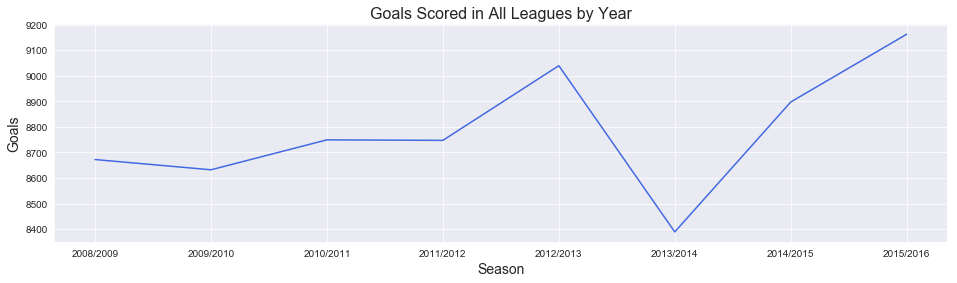

In [25]:
goals_per_year = []
seasons = leaguesFinal['season'].unique()

for i in range(0,8):
    mask = leaguesFinal['season'] == seasons[i]
    goals = leaguesFinal[mask]['home_team_goal'].sum() + leaguesFinal[mask]['away_team_goal'].sum()
    goals_per_year.append(goals)

df = pd.DataFrame([goals_per_year]).transpose()
df['Season'] = ['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015', '2015/2016']
df = df.rename(columns = {0 : 'Goals'})

#
sns.set_style("darkgrid")
plt.figure(figsize=(16, 4))
plt.plot(df['Season'], df['Goals'], color = 'royalblue')
plt.ylabel('Goals', fontsize = 14)
plt.xlabel('Season', fontsize = 14)
plt.title('Goals Scored in All Leagues by Year', fontsize = 16)
mpl.rcParams['agg.path.chunksize'] = 10000

Besides the 2013/2014 season, European soccer has seen a gradual increase in scoring every year. I'm unaware of historical rule changes and things like that which could contribute to this besides the overall offensive talent of a team increasing, but this is very similar to most other sports where the scoring has been rising consistently.

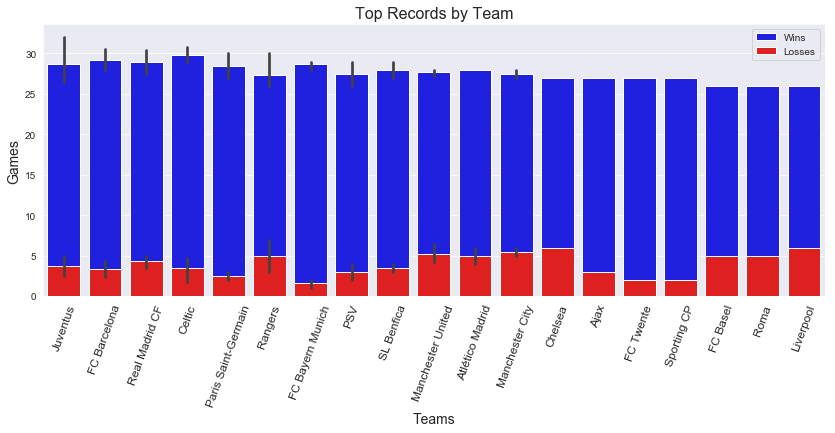

In [26]:
d = teamRecords.sort_values(by = 'Wins', ascending=False)
plt.figure(figsize=(14,5))
sns.barplot('Team', 'Wins', data = d[:50], color = 'b', label = 'Wins')
sns.barplot('Team', 'Losses', data = d[:50], color = 'r', label = 'Losses')
plt.xticks(rotation = 70, fontsize = 12)
plt.xlabel('Teams', fontsize = 14)
plt.ylabel('Games', fontsize = 14)
plt.legend(loc="best")
plt.title('Top Records by Team', fontsize = 16)
plt.show()

It's no surprise the teams at the very top of their league have a supurb win to loss ration. This would also be that teams best year if the team had more than one winning season.

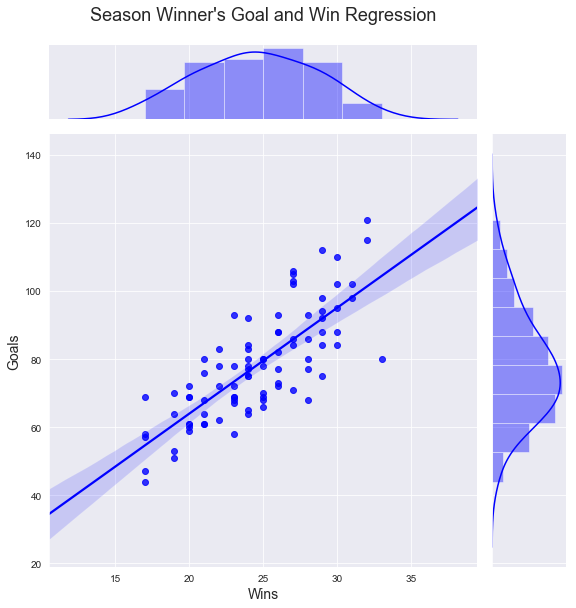

In [27]:
sns.jointplot(leagueWinners_season['Wins'], leagueWinners_season['Goals'], kind = 'reg', color = 'b', height = 8)
plt.title('Season Winner\'s Goal and Win Regression', y = 1.25, fontsize = 18)
plt.xlabel('Wins', fontsize=14)
plt.ylabel('Goals', fontsize=14)
plt.show()

We can see the extremely positive correlation between goals and wins for the best teams in each league. The regression line is nearly a 45 degree angle.

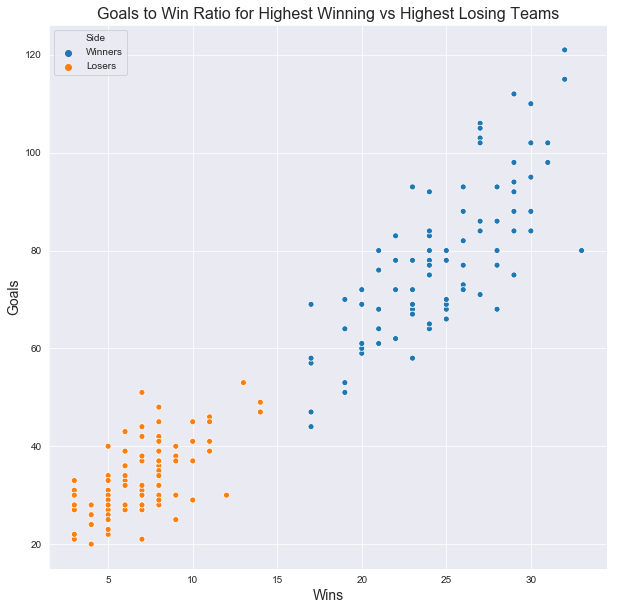

In [28]:
leagueWinners_season['Side'] = 'Winners'
leagueLosers_season['Side'] = 'Losers'
scatter = leagueWinners_season.merge(leagueLosers_season, how = 'outer')
scatter = scatter[['Wins', 'Goals', 'Side']]
plt.figure(figsize=(10,10))
plt.title('Goals to Win Ratio for Highest Winning vs Highest Losing Teams', fontsize = 16)
plt.xlabel('Wins', fontsize=14)
plt.ylabel('Goals', fontsize=14)
ax = sns.scatterplot(x = 'Wins', y = 'Goals', hue = 'Side', data = scatter)

This is the bigger picture of the last figure which now contains the closing team's goal to win ration. We can imagine with the short gap between the two clusters that the main body of all the teams in the middle would fall here with leading and trailing data points over lapping with these two clusters. The literal complete disconnect between the two clusters shows how closely related scoring and winning is.

In [29]:
# create a function that compares the winning team attributes vs losing team attributes in 
# three major categories: Build Up, Offense, and Defense

# list features that'll be compared
means = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
                'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting',
                'defencePressure', 'defenceAggression', 'defenceTeamWidth']

# fill the NaN values with the median. Had the best results compared with mean and mode
for m in means:
    leagueLosers_attributes[m].fillna((leagueLosers_attributes[m].median()), inplace=True)
    leagueWinners_attributes[m].fillna((leagueWinners_attributes[m].median()), inplace=True)

# create a distinguishing feature for the 'hue'
leagueWinners_attributes['Side'] = 'Winners'
leagueLosers_attributes['Side'] = 'Losers'
# learned this simple new way to concat haha
frames = [leagueLosers_attributes, leagueWinners_attributes]
df = pd.concat(frames)
# separate the three frames
df1 = df[['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 'Side']].reset_index() 
title1 = 'League Winner vs Loser Build Up Play Attributes'
df1.drop(['index'], axis=1, inplace=True)
df2 = df[['chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 'Side']].reset_index() 
title2 = 'League Winner vs Loser Offense Attributes'
df2.drop(['index'], axis=1, inplace=True)
df3 = df[['defencePressure', 'defenceAggression', 'defenceTeamWidth', 'Side']].reset_index()
title3 = 'League Winner vs Loser Defense Attributes'
df3.drop(['index'], axis=1, inplace=True)

# create the function for viewing
def pair_plot(df, title):
    # plot chart
    sns.pairplot(df, kind = 'reg', hue = 'Side', height = 4)
    plt.title(title, y = 2.2, x = -0.8, fontsize = 18)
    plt.show()

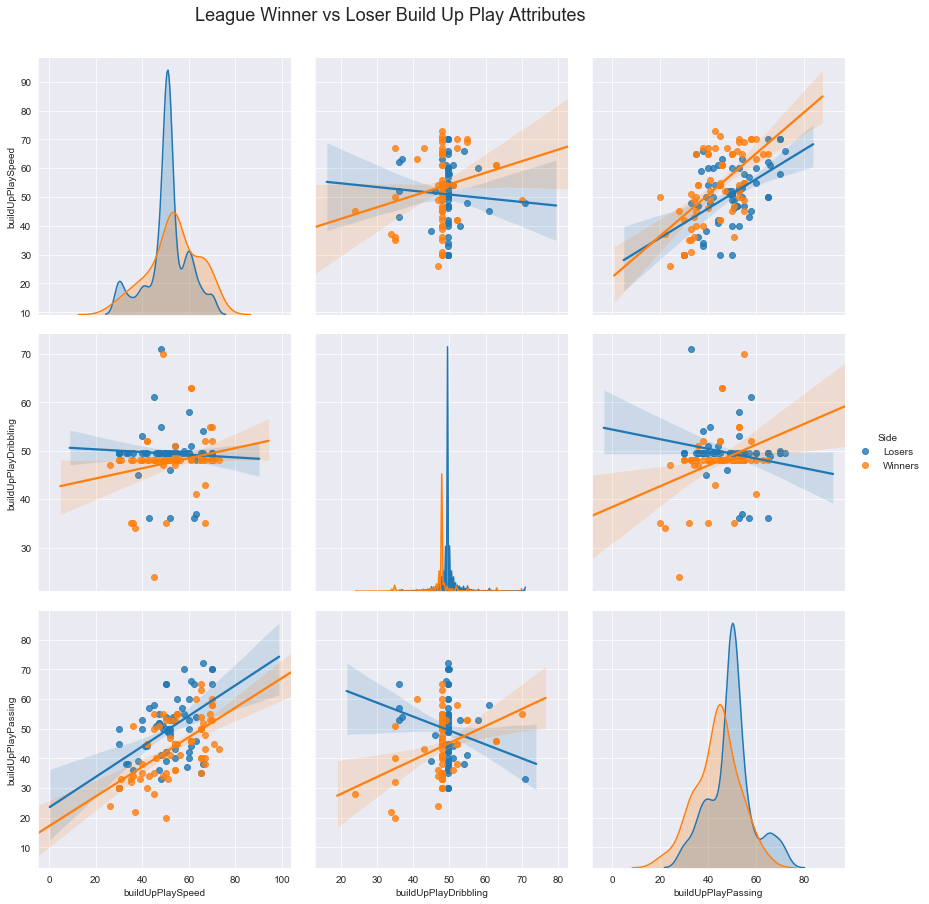

In [30]:
pair_plot(df1, title1)

There is only a single combination of categories (Speed and Passing) which both the winning and losing teams have a positive correlation, although the winning team is still stronger. Including that frame, the winning team has positive correlations with every single combination of Build Up statistic.

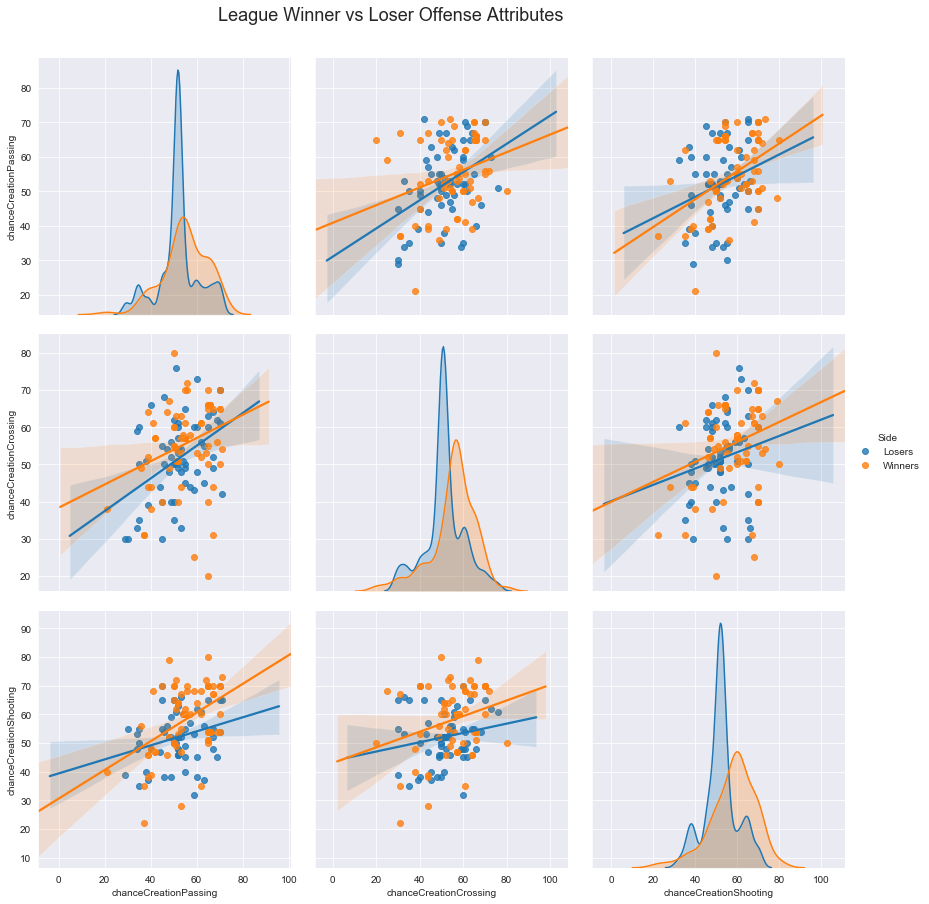

In [31]:
pair_plot(df2, title2)

Offensively this comparison was interesting because the losing teams had a more positive correlation in categories like Passing vs Crossing, although the winning teams still maintained a higher average across all teams. This seems to be a consistent trend, the winning team is on average higher than the losing teams, regardless of correlation.

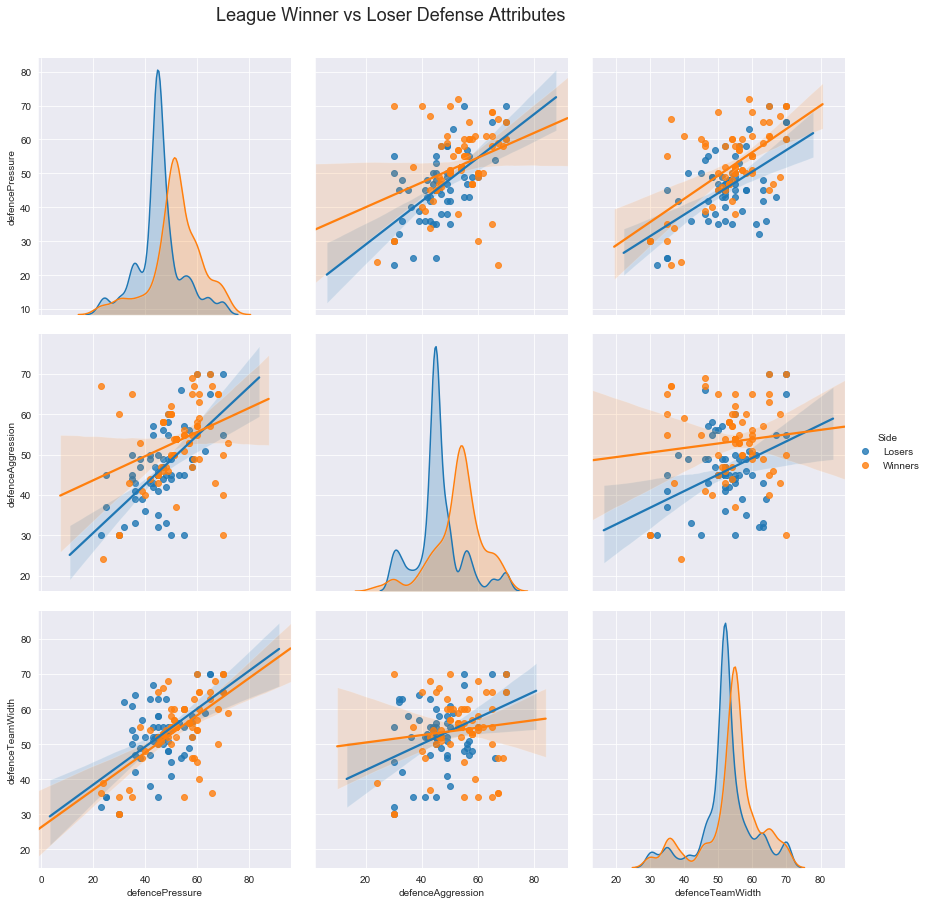

In [32]:
pair_plot(df3, title3)

The most interesting stat in this frame for me is the 'Width'. I have no idea what this stat is mean to represent relative to a team's defensive rating but it has a direct correlation to the team’s defensive pressure. The winning and losing distributions are nearly identical, and the correlation between defensive pressure and the width for both winning and losing teams are almost parallel. Interestingly similar, again like Offense the losing teams seem to have a tighter correlation between categories, but on average the winning teams have much higher statistics.

Lastly we can see in all three frames that there are a least a couple teams that are on par statistically with the best winning teams in almost every category, yet still managed to lose enough games to get grouped into the worst of the worst (thin high peaks on the losing distribution charts).

## Conclusion
We can see that just going by face value wins and losses is not really enough to judge the difference between a first place team and a last place team. In many circumstances there's a lot of grey area, with losing teams ranking in indivudal categories right on par with a winning club, but it's the high overall average - across all categories - that elevates the winning teams. 

One particular area which I believe leads to the inevitable higher goal scoring of the winning teams is the higher average and more positive correlation of Build Up Play Speed vs Build Up Play Dribbling and Build Up Play Speed vs Build Up Play Passing. In both comparisons the winning teams did significantly better. I think these stats translate into a much stronger transition game for the winning teams, meaning when they get the ball and are setting up and moving down field, they do this much more quickly and effectively than the other team, leading to more time in the offensive zone.